In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_colwidth', 200)

# import data

In [2]:
df_hist = pd.read_csv(r'.\csv\trapnet_biologicaldetailing_202302231329.csv', low_memory=False)
df_spec = pd.read_csv(r'.\csv\trapnet_specimen_202302231329.csv', low_memory=False)

# historical data without trivial fields (fields with only one entry)
unmatchable_hist = ['created_at', 'updated_at']
df_hist = df_hist.drop(unmatchable_hist, axis=1).loc[:, df_hist.nunique() > 1]
hist_sample_id_list = sorted(list(df_hist.sample_id.unique()))

# all species in historical data are 79 (atlantic salmon)
unmatchable_spec = ['created_at', 'updated_at', 'created_by_id', 'updated_by_id']
df_spec = df_spec[(df_spec.species_id==79) & (df_spec.sample_id.isin(hist_sample_id_list))].reset_index(drop=True)
df_spec = df_spec.drop(unmatchable_spec, axis=1).loc[:, df_spec.nunique() > 1]

# cast to int where appropriate
df_hist[['fork_length', 'sex_id']] = df_hist[['fork_length', 'sex_id']].astype('Int64')
df_spec[['fork_length', 'sex_id']] = df_spec[['fork_length', 'sex_id']].astype('Int64')

# archived fish data
df_arch = pd.read_csv(r'.\csv\fish_data.csv', low_memory=False)
df_arch['DATETIME'] = pd.to_datetime(df_arch['SITE_EVENT_DATE'].str.split(' ', expand=True)[0], format='%d/%m/%Y')
df_arch['old_id'] = 'GD_' + df_arch['GD_ID'].astype(str)
df_arch = df_arch[['old_id', 'DATETIME'] + [x for x in df_arch.columns if x not in ['SITE_EVENT_DATE', 'DATETIME', 'old_id']]]

In [3]:
# create a 'matching id' for matching distinctive fish characteristics

df_hist['matching_id'] = df_hist['sample_id'].astype(str) + df_hist['fork_length'].fillna(0).astype(str) + df_hist['weight'].fillna(0).astype(str) + df_hist['sex_id'].fillna(0).astype(str)
df_hist['matching_id'] = df_hist['matching_id'].str.replace('.', '_', regex=False)

df_spec['matching_id'] = df_spec['sample_id'].astype(str) + df_spec['fork_length'].fillna(0).astype(str) + df_spec['weight'].fillna(0).astype(str) + df_spec['sex_id'].fillna(0).astype(str)
df_spec['matching_id'] = df_spec['matching_id'].str.replace('.', '_', regex=False)

df_arch['arch_matching_id'] = '____' + df_arch['FORK_LENGTH'].fillna(0).round(0).astype('Int64').astype(str) + df_arch['WEIGHT'].fillna(0).astype(str) + df_arch['SEX'].fillna('U').map({'U':0,'M':1,'F':2}).astype(str)
df_arch['arch_matching_id'] = df_arch['arch_matching_id'].str.replace('.', '_', regex=False)

In [4]:
# combine historical and specimen data noting which sample they come from
#  start by assuming these are separate fish (no overlap), and confirm

all_fish = pd.concat([
    df_hist[['id', 'old_id', 'sample_id', 'matching_id']].rename({'id':'hist_id'}, axis=1),
    df_spec[['id', 'old_id', 'sample_id', 'matching_id']].rename({'id':'spec_id'}, axis=1)  # only samples that contain historical fishes are included in df_spec
], axis=0)[['old_id', 'spec_id', 'hist_id', 'sample_id', 'matching_id']]
all_fish.spec_id = all_fish.spec_id.astype('Int64')
all_fish.hist_id = all_fish.hist_id.astype('Int64')

# size of data
all_fish.shape

(102190, 5)

In [5]:
# merge with archived data

all_fish = pd.merge(all_fish, df_arch[['old_id', 'arch_matching_id']], on='old_id', how='left')

# check fish detail matches using matching id, and count the number of entries matching the archived data with spec & hist data
all_fish['fish_details_match'] = all_fish['matching_id'].str[4:] == all_fish['arch_matching_id'].str[4:]
all_fish['num_found_in_archive'] = all_fish[['spec_id', 'hist_id']].count(axis=1)

all_fish.head()

,old_id,spec_id,hist_id,sample_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
0,GD_1,<NA>,69352,4390,4390340_51,____340_51,True,1
1,GD_2,<NA>,69353,4390,4390340_62,____340_62,True,1
2,GD_3,<NA>,69354,4390,4390360_51,____360_51,True,1
3,GD_4,<NA>,69355,4390,4390360_61,____360_61,True,1
4,GD_5,<NA>,69356,4390,4390361_31,____361_31,True,1


# is there overlap between df_spec and df_hist? (no)
# how many fish characteristics match between dm_apps and archived data? (all of them)
# do these fish have matching length, weight, sex? (yes, all of them)
# how many fish are matched in archive? (all of them)

In [6]:
all_fish.describe(percentiles=[])

,spec_id,hist_id,sample_id,num_found_in_archive
count,74666.000,27524.000,102190.000,102190.000
mean,2326088.809,83113.500,6511.726,1.000
std,74105.150,7945.639,1264.222,0.000
min,1708668.000,69352.000,4390.000,1.000
50%,2333117.500,83113.500,7193.000,1.000
max,2430212.000,96875.000,8001.000,1.000


In [7]:
# every single fish matches
all_fish.fish_details_match.value_counts()

True    102190
Name: fish_details_match, dtype: int64

In [8]:
# every single fish accounted for in archived data
sum(all_fish.arch_matching_id.isnull())

0

# does the number of duplicated fish in df_spec match the number of fish in df_hist? (no)
* ie, could the historical fish be part of the specimen fish that have used duplicated old_id? (CATCH_FREQUENCY > 1)

In [9]:
# most fish in df_spec are duplicates
df_spec.old_id.nunique()

18992

In [10]:
# every single fish in df_hist is a singleton
df_hist.old_id.nunique()

27524

In [11]:
# do the duplicates in df_spec account for df_hist?

df_grouped = all_fish.groupby(['sample_id', 'old_id']).count()
df_duplicates = df_grouped[df_grouped.spec_id>1].reset_index()
duplicated_fishes = list(df_duplicates.old_id)

df_duplicates.head()

,sample_id,old_id,spec_id,hist_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
0,4404,GD_202,6,0,6,6,6,6
1,4404,GD_204,4,0,4,4,4,4
2,4404,GD_205,4,0,4,4,4,4
3,4404,GD_206,2,0,2,2,2,2
4,4404,GD_207,2,0,2,2,2,2


In [12]:
df_dupes_per_sample = df_duplicates.groupby('sample_id').count()[['old_id']].reset_index().rename({'old_id':'number_duplicates'}, axis=1).astype('Int64')
df_hist_per_sample = df_hist.groupby('sample_id').count()[['id']].reset_index().rename({'id':'number_historical'}, axis=1)
df_hist_v_dupes = pd.merge(df_dupes_per_sample, df_hist_per_sample, on='sample_id', how='outer')

df_hist_v_dupes.sample(10)

,sample_id,number_duplicates,number_historical
457,7576,19,30
395,7194,20,19
706,7886,12,86
53,4503,18,10
560,7704,4,11
185,5273,22,30
510,7645,24,203
655,7803,11,38
500,7630,7,35
767,5357,<NA>,20


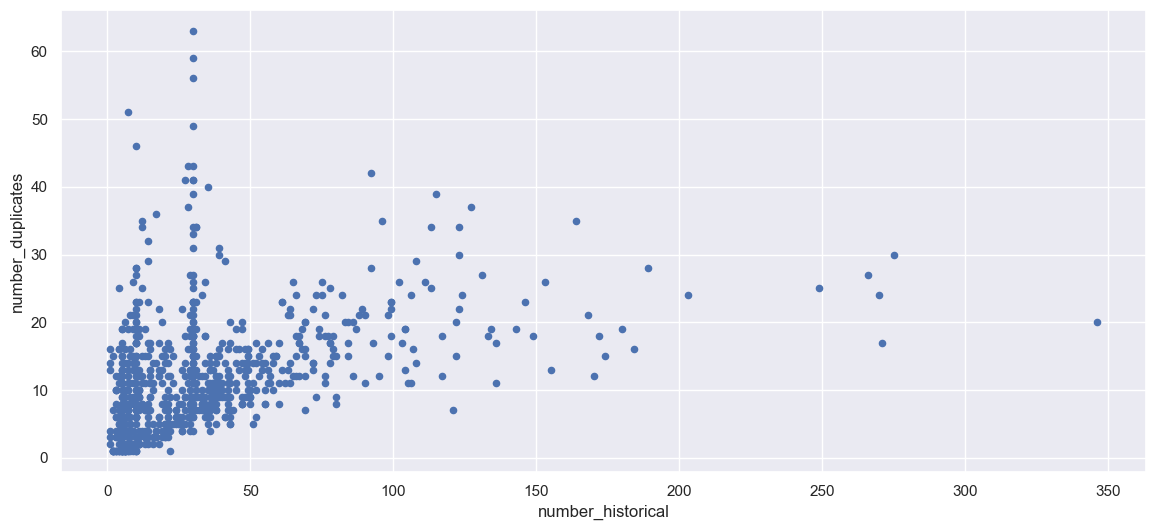

In [13]:
# historical and duplicated old_id do not look related

df_hist_v_dupes.plot(kind='scatter', x='number_historical', y='number_duplicates', figsize=(14, 6));

# does CATCH_FREQUENCY  from df_arch account for all duplicates? (yes)

In [14]:
df_catch_frequency = pd.merge(
    df_duplicates[['sample_id', 'old_id', 'spec_id']],
    df_arch[['old_id', 'CATCH_FREQUENCY']], 
    on='old_id',
    how='left'
)
df_catch_frequency.head()

,sample_id,old_id,spec_id,CATCH_FREQUENCY
0,4404,GD_202,6,6
1,4404,GD_204,4,4
2,4404,GD_205,4,4
3,4404,GD_206,2,2
4,4404,GD_207,2,2


In [15]:
# matches exactly
sum(df_catch_frequency.spec_id != df_catch_frequency.CATCH_FREQUENCY)

0

# is the catch frequency of df_hist always 1? (yes)

In [16]:
df_catch_frequency_historical = pd.merge(
    df_hist[['old_id']],
    df_arch[['old_id', 'CATCH_FREQUENCY']], 
    on='old_id',
    how='left'
)
df_catch_frequency_historical.head()

,old_id,CATCH_FREQUENCY
0,GD_1,1
1,GD_2,1
2,GD_3,1
3,GD_4,1
4,GD_5,1


In [17]:
# yes
sum(df_catch_frequency_historical.CATCH_FREQUENCY!=1)

0

# are there ever missing archived data that isn't in all_fish? (no)
* on one date: 1985-08-19
    * why were these excluded? are they different?
        * they are included but don't include historical data in their samples.
        * therefore, they are all accounted for

In [18]:
all_fish_old_ids = list(all_fish.old_id.unique())
len(all_fish_old_ids)

46516

In [19]:
df_match_all_fish = df_arch[df_arch.old_id.isin(all_fish_old_ids)].groupby(['DATETIME', 'SITE']).count().reset_index()[['DATETIME', 'SITE']]

In [20]:
df_unmatched = df_arch[~df_arch.old_id.isin(all_fish_old_ids)].copy()  # only unmatched
df_unmatched = df_unmatched[df_unmatched.SPECIES_ITIS_CODE=='161996']  # only salmon

datetimes_in_all_fish = list(df_arch[df_arch.old_id.isin(all_fish_old_ids)].DATETIME.unique())
df_unmatched = df_unmatched[df_unmatched.DATETIME.isin(datetimes_in_all_fish)]  # exclude non-matching dates

df_unmatched.shape

(13593, 33)

In [21]:
datetimes_in_still_unmatched = list(df_unmatched.DATETIME.unique())
len(datetimes_in_still_unmatched)

186

In [22]:
for date in datetimes_in_still_unmatched:
    temp_no = df_unmatched[
        (df_unmatched.DATETIME==date) 
        & (df_match_all_fish[df_match_all_fish.DATETIME==date].SITE.unique()[0] == df_unmatched[df_unmatched.DATETIME==date].SITE.unique()[0])
    ].shape[0]
    if temp_no > 0:
        print(date)

1985-08-19T00:00:00.000000000


In [23]:
missing_data = df_arch[df_arch.DATETIME=='1985-08-19'].copy()
missing_data = missing_data
missing_data.loc[missing_data.old_id.isin(df_hist.old_id.unique()), 'match_hist'] = True
missing_data.loc[missing_data.old_id.isin(df_spec.old_id.unique()), 'match_spec'] = True

In [24]:
print('not included')
missing_data[(missing_data.match_hist!=True) & (missing_data.match_spec!=True)].describe(percentiles=[]).T  # [['old_id', 'DATETIME', 'SITE', 'match_hist', 'match_spec']]

not included


,count,mean,std,min,50%,max
SURVEY,38.000,1985.000,0.000,1985.000,1985.000,1985.000
CATCHMENT_INDEX,38.000,1.500,0.507,1.000,1.500,2.000
SURVEY_TYPE,38.000,1.000,0.000,1.000,1.000,1.000
SITE_EVENT_CODE,38.000,1.000,0.000,1.000,1.000,1.000
SWEEP_NUMBER,38.000,2.079,1.024,1.000,2.000,4.000
SPECIES_LIFE_STAGE,38.000,20637.132,37017.340,140.000,2641.000,97343.000
FORK_LENGTH,16.000,56.438,17.100,43.000,53.000,103.000
FORK_LENGTH_INTERVAL_WIDTH,16.000,5.000,0.000,5.000,5.000,5.000
TOTAL_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN
WEIGHT,0.000,NaN,NaN,NaN,NaN,NaN


In [25]:
print('included')
missing_data[(missing_data.match_hist==True) | (missing_data.match_spec==True)].describe(percentiles=[]).T  # [['old_id', 'DATETIME', 'SITE', 'match_hist', 'match_spec']]

included


,count,mean,std,min,50%,max
SURVEY,363.000,1985.000,0.000,1985.000,1985.000,1985.000
CATCHMENT_INDEX,363.000,1.000,0.000,1.000,1.000,1.000
SURVEY_TYPE,363.000,1.000,0.000,1.000,1.000,1.000
SITE_EVENT_CODE,363.000,1.000,0.000,1.000,1.000,1.000
SWEEP_NUMBER,363.000,0.369,0.956,0.000,0.000,4.000
SPECIES_LIFE_STAGE,363.000,1731.000,0.000,1731.000,1731.000,1731.000
FORK_LENGTH,363.000,64.554,21.528,38.000,52.000,133.000
FORK_LENGTH_INTERVAL_WIDTH,363.000,1.639,1.468,1.000,1.000,5.000
TOTAL_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN
WEIGHT,0.000,NaN,NaN,NaN,NaN,NaN


In [26]:
# or maybe they were included in df_spec, but not in samples including historical data!?
check_specraw_for_these = list(missing_data[(missing_data.match_hist!=True) & (missing_data.match_spec!=True)].old_id)

all_spec_old_id = list(pd.read_csv(r'.\csv\trapnet_specimen_202302231329.csv', low_memory=False).old_id.unique())
len(all_spec_old_id)

293172

In [27]:
still_missing = [x for x in check_specraw_for_these if x not in all_spec_old_id]

# 0 data unaccounted for
len(still_missing)

0

# why are these data separated?
* SWEEP_NUMBER?
    * sweep 0 is not a real number -> fish detailing possibley already counted once in a sweep
    
    # check a sample with notes 
    (the inclusion of notes is arbitrary, this is just where I found the evidence)
    * check to see where the divide between historical and specimen data is (SWEEP_NUMBER)

In [28]:
df_hist[df_hist.notes!='None']

,id,fork_length,total_length,weight,age_type,river_age,notes,old_id,life_stage_id,sample_id,sex_id,status_id,matching_id
410,69762,73,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3202,1,4479,2,4,4479730_02
413,69765,87,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3205,1,4479,2,4,4479870_02
415,69767,102,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3207,1,4479,2,4,44791020_02
416,69768,120,NaN,NaN,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3208,1,4479,2,4,44791200_02
576,69928,95,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_4592,1,4512,2,4,4512950_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,86290,114,122.000,20.100,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_181620,1,7665,2,4,766511420_12
16939,86291,121,129.000,22.000,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_181621,1,7665,1,4,766512122_01
26448,95800,47,NaN,NaN,2.000,0.000,"weight 0.28, probably wrong, removed",GD_200966,1,7929,<NA>,10,7929470_00
26452,95804,49,NaN,NaN,2.000,0.000,"weight 0.28, probably wrong, removed",GD_200970,1,7929,<NA>,10,7929490_00


In [29]:
# display(df_hist[df_hist.sample_id==7929][['old_id']+[x for x in df_hist.columns if x != 'old_id']].sort_values('old_id'))
# display(df_spec[df_spec.sample_id==7929][['old_id']+[x for x in df_spec.columns if x != 'old_id']].sort_values('old_id'))

In [30]:
# what is different starting after GD_201051

## SWEEP_NUMBER==0

df_arch[df_arch.old_id.isin(all_fish[all_fish.sample_id==7929].old_id.unique())][['old_id']+[x for x in df_arch.columns if x != 'old_id']].head(95).tail(10)

,old_id,DATETIME,SURVEY,SITE,CATCHMENT_NAME,CATCHMENT_INDEX,SURVEY_TYPE,SITE_EVENT_CODE,SWEEP_NUMBER,RECORD_IDENTIFIER,SPECIES_ITIS_CODE,SPECIES_LIFE_STAGE,ORIGIN,FISH_STATUS,FORK_LENGTH,FORK_LENGTH_INTERVAL_WIDTH,TOTAL_LENGTH,WEIGHT,WEIGHT_RESOLUTION,WEIGHT_PRECISION,FILE_TYPE,CATCH_FREQUENCY,FISH_SIZE,RIVER_AGE,AGE_TYPE,SEX,MATURITY,BIOLOGICAL_REMARKS,BIOLOGICAL_SAMPLE,SCALE_SAMPLE,SCALE_SAMPLE_ID,GD_ID,arch_matching_id
201046,GD_201047,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556726,161996,1731.000,W,RS,82.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201047,____820_00
201047,GD_201048,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556727,161996,1731.000,W,RS,83.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201048,____830_00
201048,GD_201049,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556728,161996,1731.000,W,RS,84.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201049,____840_00
201049,GD_201050,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556729,161996,1731.000,W,RS,85.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201050,____850_00
201050,GD_201051,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556730,161996,1731.000,W,RS,122.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,2.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201051,____1220_00
201052,GD_201053,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556922,161996,1731.000,W,RS,44.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201053,____440_00
201053,GD_201054,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556923,161996,1731.000,W,RS,44.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201054,____440_00
201054,GD_201055,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556924,161996,1731.000,W,RS,45.000,1.000,NaN,NaN,0.000,0.100,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,"weight 0.28, probably wrong, removed",1.000,NaN,NaN,201055,____450_00
201055,GD_201056,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556925,161996,1731.000,W,RS,46.000,1.000,NaN,NaN,0.000,0.100,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,"weight 0.28, probably wrong, removed",1.000,NaN,NaN,201056,____460_00
201056,GD_201057,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556926,161996,1731.000,W,RS,46.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201057,____460_00


# is sweep number always non-zero for specimen? (almost yes)

In [31]:
df_arch[df_arch.old_id.isin(df_spec.old_id.unique())].SWEEP_NUMBER.value_counts()

1.000    6338
2.000    4522
3.000    3252
0.500    2150
4.000    2060
5.000     664
0.000       6
Name: SWEEP_NUMBER, dtype: int64

# is sweep number always zero for biological / historical? (yes)

In [32]:
df_arch[df_arch.old_id.isin(df_hist.old_id.unique())].SWEEP_NUMBER.value_counts()

0.000    27524
Name: SWEEP_NUMBER, dtype: int64

# let's check those 6 exceptions - sweep = 0 in specimen table
* CONFIRMED in SQL
* NOTE: for data without historical data, sweep_number=0 is much more common (from SQL)

In [33]:
df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)]

,old_id,DATETIME,SURVEY,SITE,CATCHMENT_NAME,CATCHMENT_INDEX,SURVEY_TYPE,SITE_EVENT_CODE,SWEEP_NUMBER,RECORD_IDENTIFIER,SPECIES_ITIS_CODE,SPECIES_LIFE_STAGE,ORIGIN,FISH_STATUS,FORK_LENGTH,FORK_LENGTH_INTERVAL_WIDTH,TOTAL_LENGTH,WEIGHT,WEIGHT_RESOLUTION,WEIGHT_PRECISION,FILE_TYPE,CATCH_FREQUENCY,FISH_SIZE,RIVER_AGE,AGE_TYPE,SEX,MATURITY,BIOLOGICAL_REMARKS,BIOLOGICAL_SAMPLE,SCALE_SAMPLE,SCALE_SAMPLE_ID,GD_ID,arch_matching_id
2366,GD_2367,1971-09-08,1971,13,MIRAMICHI,2,1,1,0.000,8628334,161996,1731.000,W,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FRY,0.000,SCALE,M,NaN,NaN,1.000,NaN,NaN,2367,____00_01
2367,GD_2368,1971-09-08,1971,13,MIRAMICHI,2,1,1,0.000,8628335,161996,1731.000,W,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FRY,0.000,SCALE,M,NaN,NaN,1.000,NaN,NaN,2368,____00_01
3038,GD_3039,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626673,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3039,____00_02
3039,GD_3040,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626674,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3040,____00_02
3040,GD_3041,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626675,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3041,____00_02
3041,GD_3042,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626676,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,M,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3042,____00_01


In [34]:
# sample ids for exceptions
list(df_spec[df_spec.old_id.isin(df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)].old_id)].sample_id.unique())

[4456, 4475]

In [35]:
# fish ids for exceptions - these are all listed as sweep = 0.0
list(df_spec[df_spec.old_id.isin(df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)].old_id)].id.unique())

[2230972, 2230973, 2233822, 2233823, 2233824, 2233825]

# could any of the df_hist be a sample from df_spec double counted?
* potentially with weight, where spec is missing weight

In [36]:
summary = pd.merge(
    df_spec[['sample_id', 'fork_length', 'weight', 'river_age', 'sex_id']].groupby('sample_id').agg(['count', 'max', 'min']),
    df_hist[['sample_id', 'fork_length', 'weight', 'river_age', 'sex_id']].groupby('sample_id').agg(['count', 'max', 'min']),
    on='sample_id'
).rename({'fork_length_x':'fork_length_spec', 'fork_length_y':'fork_length_hist'}, axis=1)
summary.shape

(775, 24)

In [37]:
# biological samples outside of measurement tolerance
measurement_tolerance = 5
summary[
    ((summary.fork_length_spec[['max']] < summary.fork_length_hist[['max']] - measurement_tolerance)['max'])  # max hist too big
    | ((summary.fork_length_spec[['min']] > summary.fork_length_hist[['min']] + measurement_tolerance)['min'])  # min hist too small
][['fork_length_spec', 'fork_length_hist']].shape[0], summary.shape[0]

(50, 775)

# count potential matches

In [38]:
%%time

length_tolerance = 1
weight_tolerance = 1
potential_matches = {}
strong_matches = {}
last_sample = 0
df = pd.DataFrame()
null_weight_count = 0

for i, row in df_hist.iterrows():
    fish_id, sample_id, fork_length, weight = row[['id', 'sample_id', 'fork_length', 'weight']]
    if last_sample != sample_id:
        df = df_spec[df_spec.sample_id==sample_id]
        
    if not df.empty:
        results = df[
            ((df.fork_length>=fork_length-length_tolerance) & (df.fork_length<=fork_length+length_tolerance)) 
            & (
                ((df.weight>=weight-weight_tolerance) & (df.weight>=weight-weight_tolerance))
                | df.weight.isnull()  # maybe track whether weight is null
            )
        ]
        results = results[~results.id.isin(potential_matches.values())]
        if not results.empty:
            potential_matches.update({int(str(row.id)): results.iloc[0].id})
            results['weight'].isnull()
            if results['weight'].isnull().iloc[0]:
                null_weight_count += 1
            else:
                strong_matches.update({int(str(row.id)): results.iloc[0].id})
            
    else:
        pass  # there are no matches, maybe make a note?
    
    last_sample = sample_id


Wall time: 58.2 s


In [39]:
# confirm only distinct matches are compiled
len(potential_matches.values()), len(set(potential_matches.values()))

(15560, 15560)

In [40]:
# most of the matches are missing weight, so are just length
null_weight_count

15289

In [41]:
# only 271 strong matches
len(strong_matches.values()), len(set(strong_matches.values()))

(271, 271)

# are there samples with more hist than spec?

In [42]:
type_counts = pd.merge(
    df_hist.groupby('sample_id').count().reset_index()[['sample_id', 'id']].rename({'id':'hist_count'}, axis=1), 
    df_spec.groupby('sample_id').count().reset_index()[['sample_id', 'id']].rename({'id':'spec_count'}, axis=1),
    on='sample_id', 
    how='left'
)
type_counts.spec_count = type_counts.spec_count.astype('Int64')

# none of these fish could be double counted

In [43]:
type_counts[type_counts.spec_count.isna()]

,sample_id,hist_count,spec_count
0,4390,34,<NA>
1,4391,14,<NA>
2,4392,13,<NA>
3,4393,3,<NA>
4,4394,21,<NA>
5,4395,17,<NA>
6,4396,9,<NA>
7,4397,23,<NA>
8,4398,19,<NA>
9,4399,6,<NA>


# many of these fish could not be double counted
(but it is possible that some still are)

In [44]:
type_counts[type_counts.hist_count > type_counts.spec_count]

,sample_id,hist_count,spec_count
189,5246,22,7
205,5266,14,2
208,5270,20,3
209,5271,30,5
267,5348,11,10
276,5357,20,2
451,7532,17,6
747,7857,51,32


# CONCLUSIONS:
* there is no overlap between the historical fish (BiologicalDetailing) and the specimen (Specimen) in dm_apps
    * ie, BiologicalDetailing and Specimen are mutually exclusive
* every single fish in the historical data is a singleton
    * ie, if imported from the historical table to the specimen table, no multiple fish are required
* all data is consistent with archived data
* there is no archived data that isn't included in the dm_apps data (for the dates and sites considered)
* historical data (BiologicalDetailing) appears to be specimen data with no sweep number
    * not sure if this was an import issue or a deliberate choice
    * cannot currently explain the 6 exceptions to this trend (out of 102,190)


# differences between tables

In [45]:
# missing from specimen and in historical
[x for x in df_hist.columns if x not in df_spec.columns]

['total_length']

In [46]:
# missing from historical and in specimen
[x for x in df_spec.columns if x not in df_hist.columns]

['sweep_id', 'smart_river_age', 'smart_river_age_type']

In [47]:
# non-null total length data - could go into notes
sum(df_hist.total_length.notnull())

1663

In [48]:
# how does fork length compare to total length>?
(df_hist[df_hist.total_length.notnull()].total_length / df_hist[df_hist.total_length.notnull()].fork_length).describe()

count   1643.000
mean       1.067
std        0.019
min        0.966
25%        1.054
50%        1.067
75%        1.078
max        1.180
dtype: float64

# Check a few entries in dm_apps
* what I've checked looks correct

In [49]:
list_of_samples = list(df_hist.sample_id.unique())
rand_sample = np.random.choice(list_of_samples)

print('\n', f'http://127.0.0.1:8000/en/trapnet/samples/{rand_sample}/view/')

display(
    df_spec[df_spec.sample_id==rand_sample]
    .groupby('old_id')
    .count()[['id']]
    .rename({'id':'counts'}, axis=1)
    .sort_values('counts', ascending=False)
    .head()
)

display(all_fish[all_fish.sample_id==rand_sample])


 http://127.0.0.1:8000/en/trapnet/samples/5366/view/


,counts
old_id,
GD_38758,11
GD_38759,3
GD_38760,3
GD_38766,3
GD_38767,3


,old_id,spec_id,hist_id,sample_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
3588,GD_38743,<NA>,72940,5366,5366481_30,____481_30,True,1
3589,GD_38744,<NA>,72941,5366,5366481_41,____481_41,True,1
3590,GD_38745,<NA>,72942,5366,5366501_62,____501_62,True,1
3591,GD_38746,<NA>,72943,5366,5366511_61,____511_61,True,1
3592,GD_38747,<NA>,72944,5366,5366531_72,____531_72,True,1
3593,GD_38748,<NA>,72945,5366,5366531_92,____531_92,True,1
3594,GD_38749,<NA>,72946,5366,5366541_82,____541_82,True,1
3595,GD_38750,<NA>,72947,5366,5366551_90,____551_90,True,1
3596,GD_38751,<NA>,72948,5366,5366552_02,____552_02,True,1
3597,GD_38752,<NA>,72949,5366,5366572_50,____572_50,True,1
